# Clean!!!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from behavelet import wavelet_transform
from sklearn.decomposition import PCA 

# K-MEAN
from sklearn.cluster import KMeans
# GMM clustering
from sklearn import mixture
#correlation
import seaborn as sns

C:\Users\Haha\anaconda3\lib\site-packages\behavelet\morlet.py:26: UserWarning: CuPy was not found, so GPU functionality is unavailable. See https://github.com/cupy/cupy#installation for installation instructions
  warnings.warn('CuPy was not found, so GPU functionality is unavailable. '


# Loading the behavioural/neural data

In [2]:
beh_data_dir = "data/COBAR_behaviour_incl_manual.pkl"
beh_df = pd.read_pickle(beh_data_dir)


In [3]:
neural_data_dir = beh_data_dir = "data/COBAR_neural.pkl"
neural_df = pd.read_pickle(neural_data_dir)


## Part 2: Data pre-processing

### 1. ΔF/F

In [4]:
#Δ𝐹/𝐹 = (F − Fb)/𝐹b , where Fb is the baseline fluorescence.
# return baselined neural data
def neural_dF_F(data):
    rlt_Df_f=data.copy()
    nb_neurons = np.size(data,1)
    
    for j in np.arange(nb_neurons-1): 
        baseline = data['neuron_' + str(j)].rolling(window=3).mean()
        rlt_Df_f['neuron_' + str(j)] = (data['neuron_' + str(j)]-abs(baseline.min()))/abs(baseline.min())
    return rlt_Df_f

### 2. Noise reduction

In [5]:
from scipy.signal import butter, filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

#filter angles in beh data
fs=100.0
order=2
cutoff=20
filtered_beh_df = beh_df.copy(deep=True)
angl=beh_df.filter(regex="angle")
filtered_angl = butter_lowpass_filter(angl, cutoff, fs, order)
filtered_beh_df.iloc[:,2:44]=filtered_angl
#filter neurons reading in neural data
filtered_neural_df = neural_df.copy(deep=True) #necessary to deep copy dataaframe
fs=16.0
order=2
cutoff=2.5
neurons=neural_df.filter(regex="neuron")
filtered_neurons = butter_lowpass_filter(neurons, cutoff, fs, order)
filtered_neural_df.iloc[:,1:124]=filtered_neurons

filtered_neural_df = neural_dF_F(filtered_neural_df)

In [6]:
# Global Parameters
nb_trials = 12

#time vector
t = filtered_neural_df["t"]
time = t[t.index.get_level_values("Trial")==0]
time_offset = time.iloc[-1]
for i in range(nb_trials-1):
    time_trial_i = t[t.index.get_level_values("Trial")==(i+1)]
    time = pd.concat([time, time_trial_i+time_offset], axis=0)
    time_offset = time_offset + time_trial_i.iloc[-1]

# Investigate clustering of neurons' activity: find neurons that correlate with each other

This section aims at finding neurons that activate at similar times. This is done by doing a Principal Component Analysis (PCA) followed by clastering. The clastering is then evaluated using inter-neuron correlation.

## PCA 

In [72]:
# Functions required for PCA 

# normalise the data
def normalise(data):
    Feature_scaler = sklearn.preprocessing.StandardScaler().fit(data)
    return sklearn.preprocessing.scale(data)

# apply PCA:  
# input samples: neurons
# input features: time samples
def PCA_temporal(data_norm, time, plot=False):

    pca = PCA(n_components=27)
    data_new = pca.fit_transform(data_norm.T)
    print('Variance explained by first 27 pricipal components:')
    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_))
    
    if plot:
        #plot loadings
        fig, ax = plt.subplots()
        loadings = pd.DataFrame(pca.components_[0:2].T, columns=['PC1', 'PC2'])
        time1 = np.ones(len(loadings['PC1']))/16
        plt.plot(time, loadings['PC1'], label = 'PC1', alpha=0.5)
        plt.plot(time, loadings['PC2'], label = 'PC2', alpha=0.5)
        plt.title('PCA Loadings of Neural Activity')
        plt.xlabel('Time point [s]')
        plt.ylabel('PCA weight')
        plt.legend()
        plt.show()
        fig.savefig('report_images/pca_neuro_temporal_loadings.png')
        
        fig, ax = plt.subplots()
        #scatter plot of first two components
        plt.scatter(data_new[:,0], data_new[:,1], alpha = 0.5) 
        plt.title('PCA Projected Neurons')
        plt.xlabel('PCA component 1 ({:.2f}%)'.format(100*pca.explained_variance_ratio_[0]))
        plt.ylabel('PCA component 2 ({:.2f}%)'.format(100*pca.explained_variance_ratio_[1]))
        plt.show()
        fig.savefig('report_images/pca_neuro_temporal_scatter.png')
        
    return data_new

Variance explained by first 27 pricipal components:
[0.27332419 0.26424122 0.06765547 0.03619374 0.0326937  0.0254746
 0.02292318 0.01734588 0.01707517 0.01548904 0.01295125 0.01225216
 0.01175104 0.01067083 0.00938809 0.00884929 0.00829762 0.00770559
 0.00727819 0.0061492  0.00559604 0.00521733 0.00486268 0.00450528
 0.00439967 0.00416695 0.00378494]
0.9002423351386902


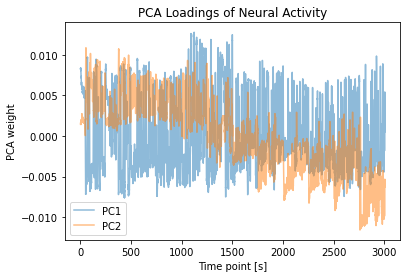

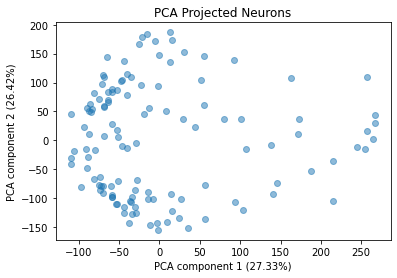

In [73]:
# PCA implementation (all trials are used as data)
X = filtered_neural_df.filter(regex="neuron")

X_norm = normalise(X)
X_new = PCA_temporal(X_norm, time, plot=True)


## clustering
After the dimension reduction done with the PCA, the neurons can be clastered. These clusters represent neurons that have similar signals.

In [53]:
# cluster data using kmeans
# returns the classes and class names
def kmeans_cluster(data, nb_clusters, plot=False):
    
    #fit kmeans
    kmeans = KMeans(n_clusters=nb_clusters, init='random', n_init=1, verbose=0)
    kmeans.fit(data)
    labels = kmeans.labels_
    class_names = np.unique(labels)

    if plot:
        #plot scatter points with colours of KMEANS clusters
        for i in range(len(class_names)):
                select_indices = np.where(labels == class_names[i])
                plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.5)  

        plt.xlabel('feature 1')

        plt.ylabel('feature 2')
        plt.title('KMEANS clustering')
        plt.legend(class_names)
        plt.show()
    
    return labels, class_names

# cluster data using GMM
# returns the classes and class names
def GMM_cluster(data, nb_components, plot=False):
    
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=nb_components, covariance_type='full').fit(data)
    
    labels = gmm.predict(data)
    class_names = np.unique(labels)

    if plot:
        #plot scatter points with colours of GMM clusters
        for i in range(len(class_names)):
                select_indices = np.where(labels == class_names[i])
                plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.5)  

        plt.xlabel('feature 1')

        plt.ylabel('feature 2')
        plt.title('GMM clustering')
        plt.legend(class_names)
        plt.show()
        
    return labels, class_names

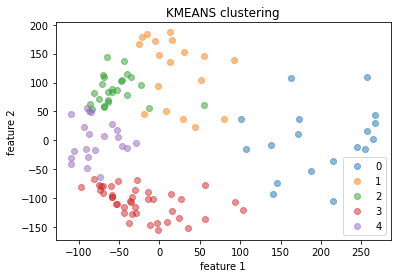

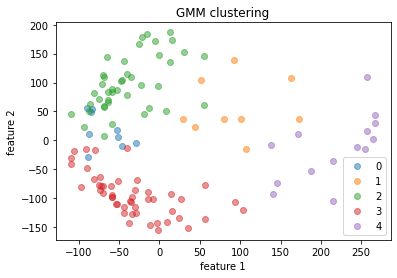

In [54]:
kmeans_labels, kmeans_names = kmeans_cluster(X_new, nb_clusters=5, plot=True)
GMM_labels, GMM_names = GMM_cluster(X_new, nb_components=5, plot=True)

## Correlation
To evaluate the similarity between the signals of neurons from the same cluster, we can find their correlation coefficients.

In [28]:
# plot correlation coefficient of given data
def plot_correlation_coeff(data, title):
    #Set up the matplotlib figure
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,10))

    #Compute the correlation matrix
    correlation = data

    corr = correlation.corr()

    #Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    #Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    #Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set_xlabel('neuron id')
    ax.set_ylabel('neuron id')
    ax.title.set_text(title)

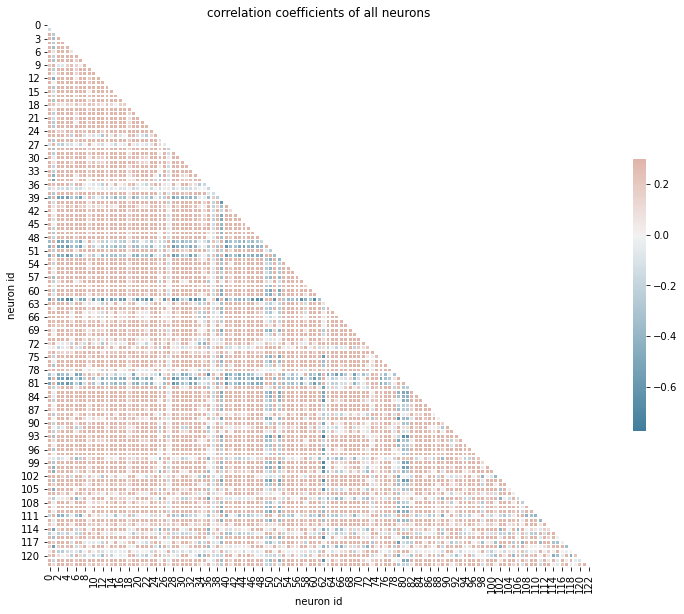

In [51]:
# correlation coefficient of all the neurons
plot_correlation_coeff(pd.DataFrame(data=X1_norm), title='correlation coefficients of all neurons')

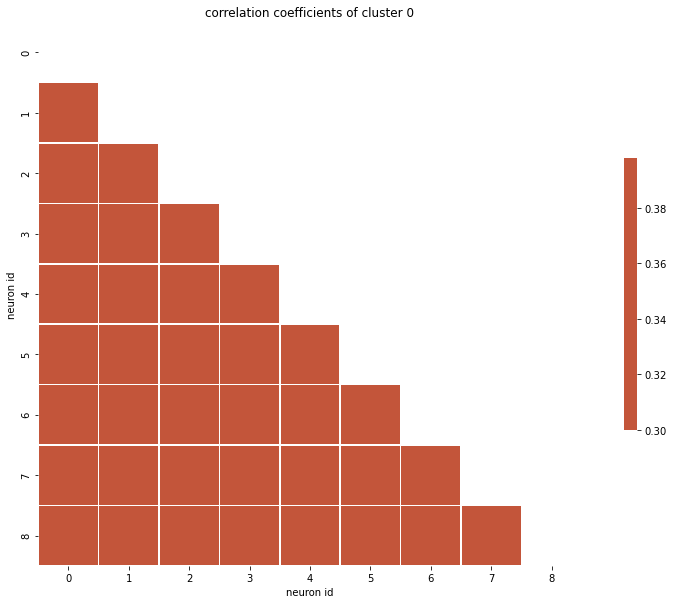

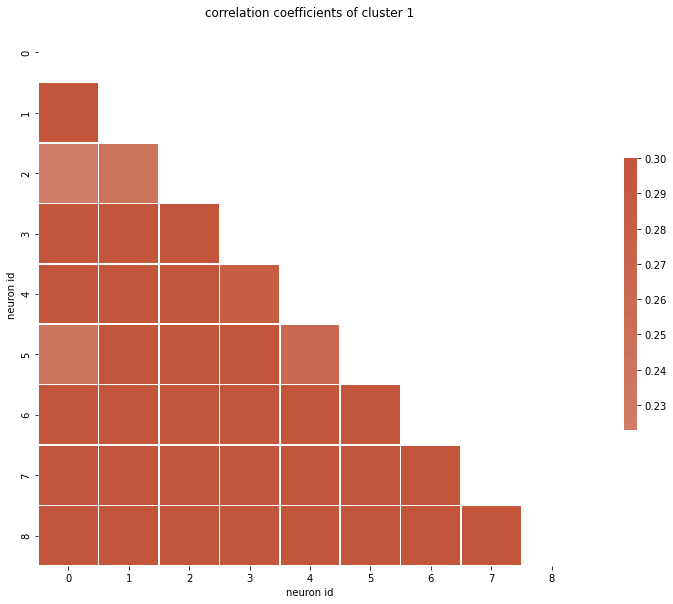

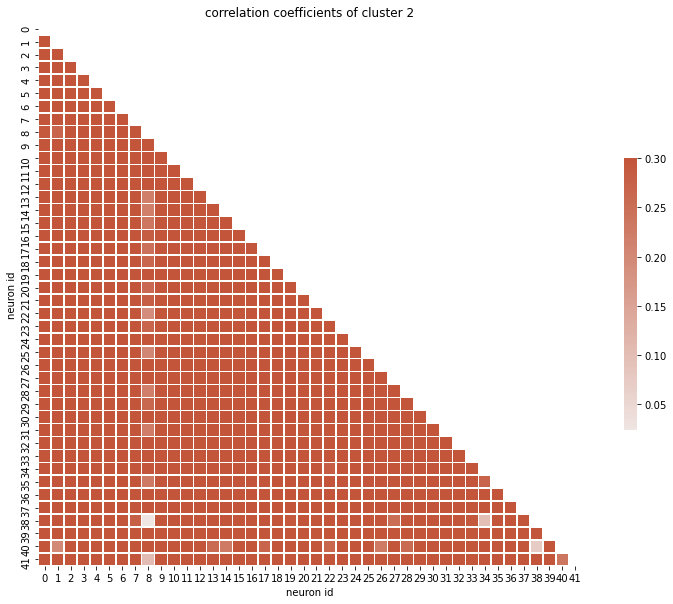

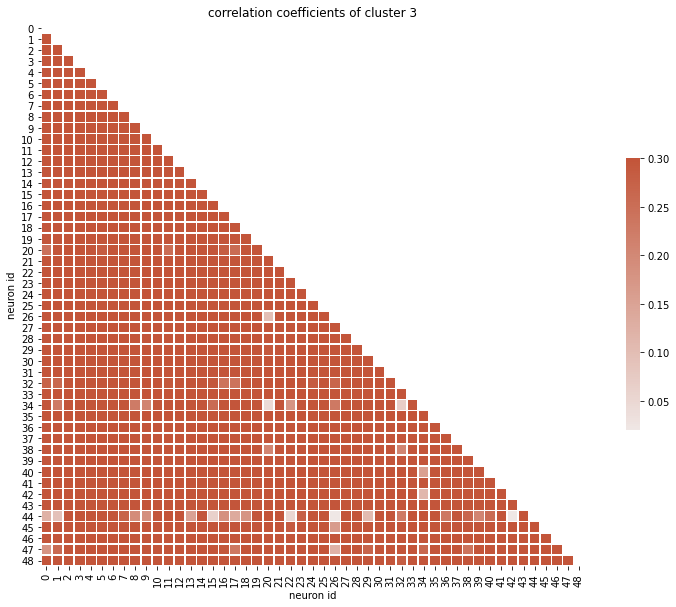

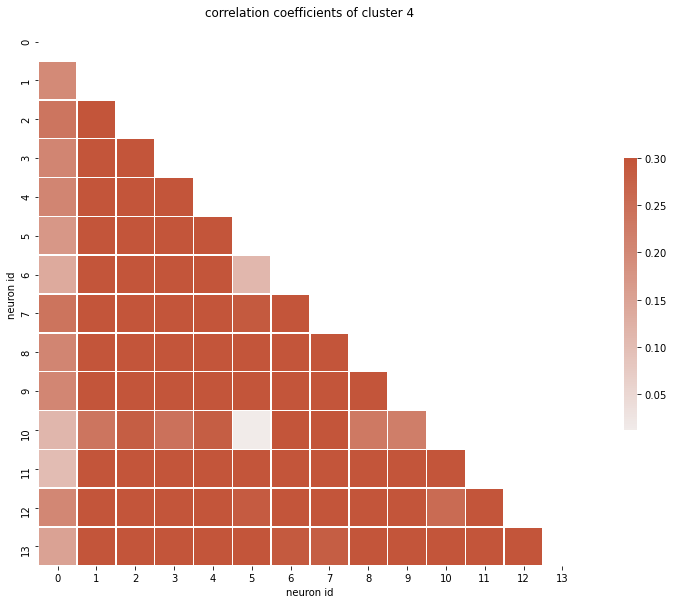

In [56]:
for i in range(len(GMM_names)):  
    neurons_cluster = np.where(GMM_labels == GMM_names[i])[0]
    plot_correlation_coeff(pd.DataFrame(data=X_norm[:,neurons_cluster]), title='correlation coefficients of cluster {}'.format(i))

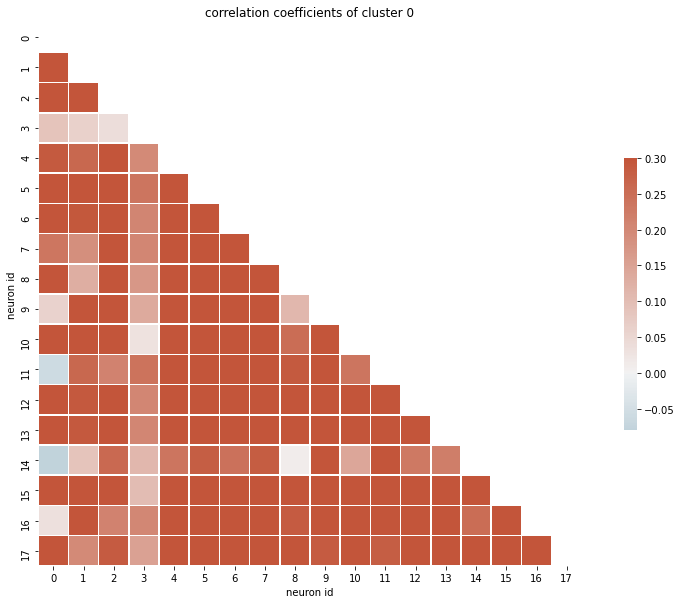

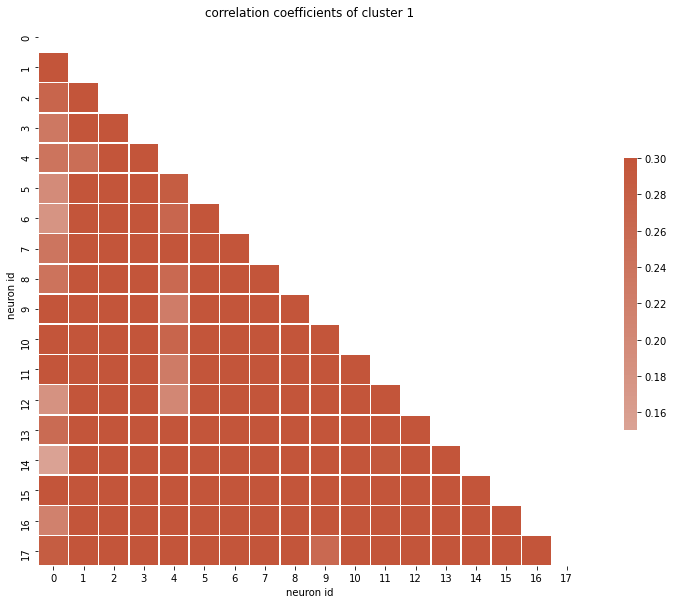

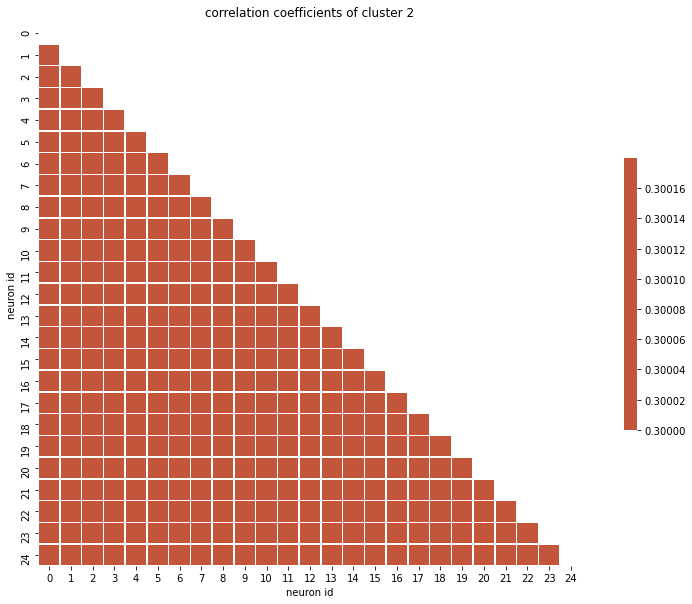

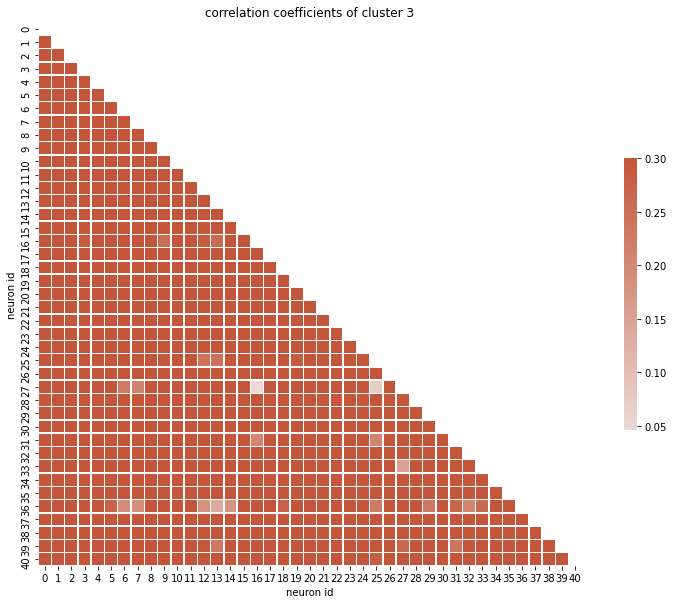

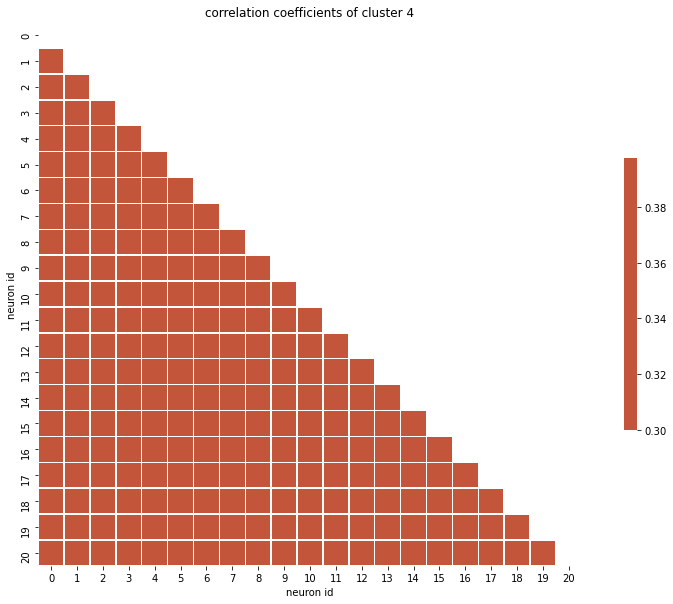

In [55]:

for i in range(len(kmeans_names)):  
    neurons_cluster = np.where(kmeans_labels == kmeans_names[i])[0]
    plot_correlation_coeff(pd.DataFrame(data=X_norm[:,neurons_cluster]), title='correlation coefficients of cluster {}'.format(i))